# TBM notebook

### Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ptk_code.utils import *

### Select Transform

In [2]:
transform = 'PLOT' 
#transform = 'RCDT' 
#transform = 'CLOT' 

### Select Regression Model

In [3]:
#model = 'PLDA' # 'PCA','PLDA','NS','CCA'
model = 'PLDA'
#model = 'PCA'
#model = 'NS'
#model = 'CCA'

### Load Data

In [4]:
# dataset = 'synthetic_2D'
# dataset = 'cell_data'
dataset = 'immuno_cells'

train_dir = './data/'+dataset+'/training/'
(x_train_init, y_train) = load_image_data(train_dir)
test_dir = './data/'+dataset+'/testing/'
(x_test_init, y_test) = load_image_data(test_dir)

In [5]:
# Visualizing the shapes of the dataset
print('Test_size: ', x_train_init.shape)
print('Train size: ', y_train.shape)
print('Test_size: ', x_test_init.shape)
print('Train size: ', y_test.shape)

Test_size:  (20, 100, 100)
Train size:  (20,)
Test_size:  (16, 100, 100)
Train size:  (16,)


In [6]:
def visualize(figsize=(15, 15),**images):
    """Plots images in one row."""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'gray')
    plt.show()

1
0


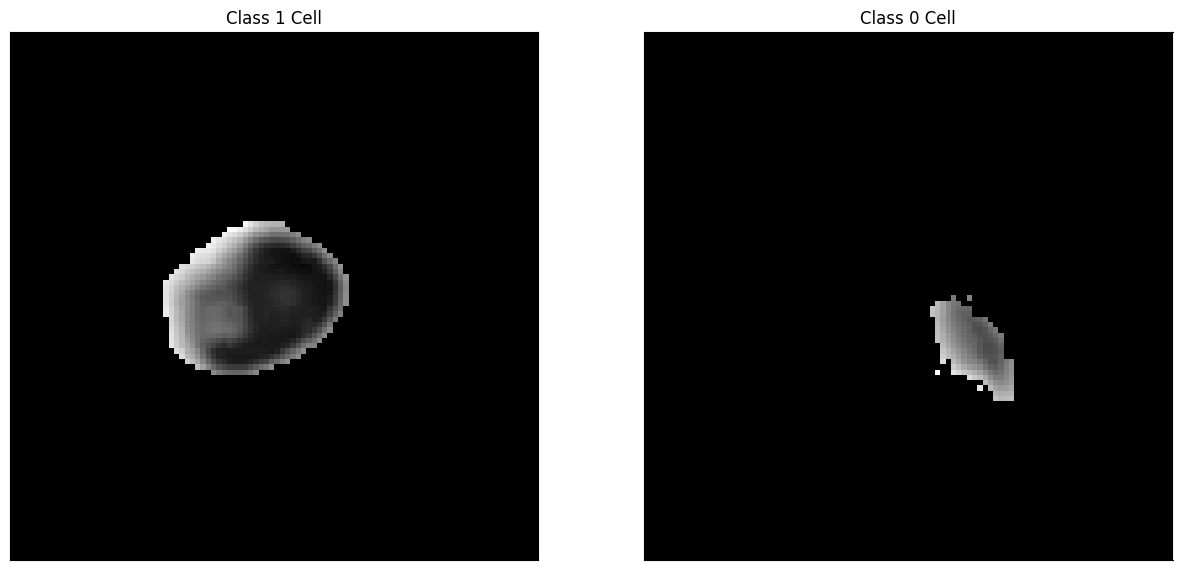

In [7]:
i, j = 19, 6
print(y_train[i])
print(y_train[j])
visualize(class_1_cell = x_train_init[19], class_0_cell = x_train_init[6])

### Data Pre-processing

In [8]:
if model == 'NS' and transform == 'RCDT':
    x_train = x_train_init
    x_test = x_test_init
else:
    from ptk_code.preprocessing import image_preprocessing
    
    n_training = x_train_init.shape[0]
    data = np.concatenate([x_train_init,x_test_init],axis=0)
    data_p = image_preprocessing(data,flag_tran=0,flag_scale=0,flag_orient=0,flag_group=0)
    data_p[np.where(data_p<0)] = 0
    x_train = data_p[:n_training,:]
    x_test = data_p[n_training:,:]

### 1. Apply Transform

In [9]:
template = np.ones(x_train[0].shape, dtype=x_train.dtype)
if transform == 'RCDT':
    from ptk_code.TBM_RCDT import batch_RCDT
    
    thetas = np.linspace(0,180,180)
    batch_rcdt = batch_RCDT(thetas,rm_edge=False)

    x_train_hat = batch_rcdt.forward(x_train, template)
    x_test_hat = batch_rcdt.forward(x_test, template)
elif transform == 'CLOT':
    # Generate reference image by taking mean of RCDT
    from ptk_code.TBM_RCDT import batch_RCDT
    from ptk_code.support.optrans.utils import signal_to_pdf

    thetas = np.linspace(0,180,180)
    batch_rcdt = batch_RCDT(thetas,rm_edge=False)
    x_train_hat = batch_rcdt.forward_seq(x_train, template)
    xhat_mean = np.mean(x_train_hat,axis=0)
    x0 = np.abs(batch_rcdt.inverse(xhat_mean, template))
    img0 = signal_to_pdf(x0, sigma=1., epsilon=8., total=100.)

    # Calculate VOT
    from ptk_code.TBM_CLOT import batch_VOT

    lr=1e-4 
    alpha=0. 
    max_iter=100
    batch_vot = batch_VOT(lr, alpha, max_iter)
    x_train_hat = batch_vot.forward_seq(x_train, img0)
    x_test_hat = batch_vot.forward_seq(x_test, img0)
elif transform == 'PLOT':
    from ptk_code.TBM_PLOT import batch_PLOT
    batch_plot = batch_PLOT(Nmasses = 185)
    x_template=np.mean(x_train,axis=0)
    x_train_hat, x_test_hat, Pl_tem, P_tem = batch_plot.forward_seq(x_train, x_test, x_template)
    mean_x_train_hat=x_train_hat.mean(axis=0)

### 2. Regression Model

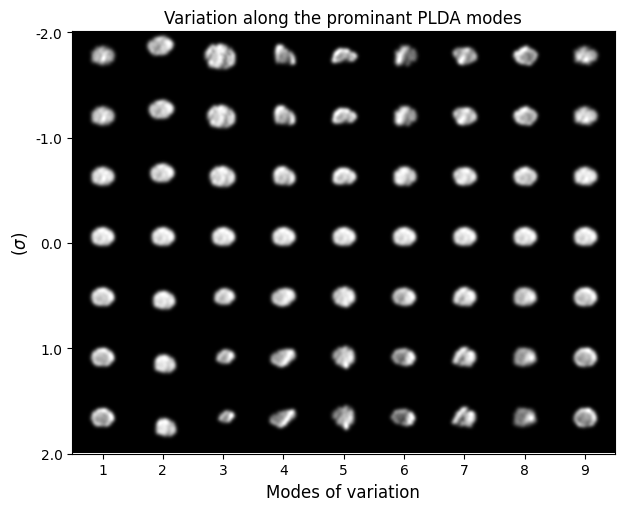

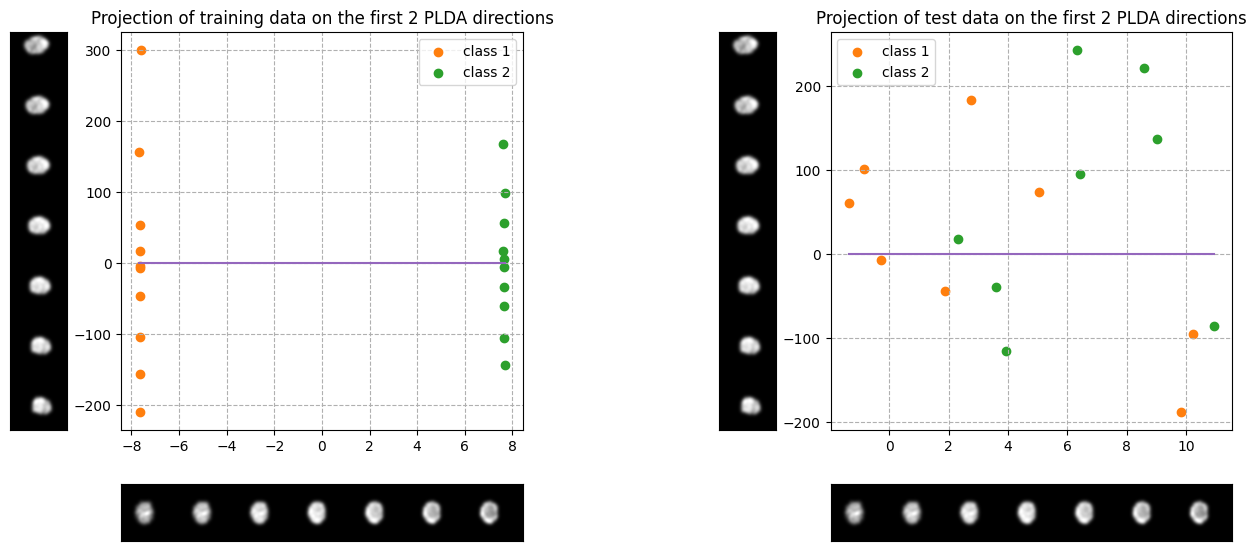

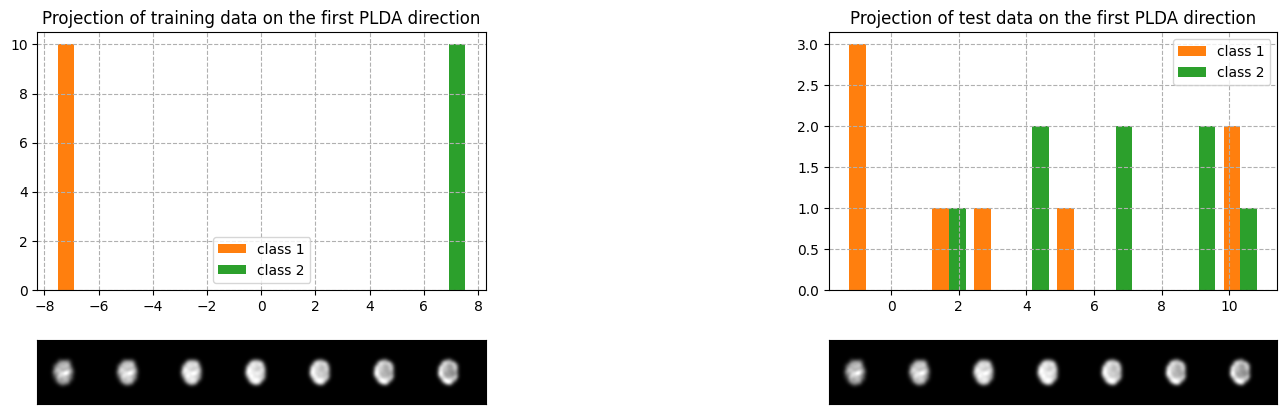

In [10]:
if model == 'PCA':
    if transform == 'RCDT':
        from ptk_code.TBM_RCDT import RCDT_PCA
        n_components = 12
        rcdt_pca = RCDT_PCA(n_components)
        b_hat, p_tr, p_te = rcdt_pca.rcdt_pca(x_train_hat, y_train, x_test_hat, y_test, template)
        rcdt_pca.visualize(directions=9, points=7, thetas=thetas, SD_spread=2)
    elif transform == 'CLOT':
        from ptk_code.TBM_CLOT import VOT_PCA
        n_components = 12
        clot_pca = VOT_PCA(n_components,lr, alpha, max_iter)
        b_hat, p_tr, p_te = clot_pca.vot_pca(x_train_hat, y_train, x_test_hat, y_test, img0)
        clot_pca.visualize(directions=9, points=7, SD_spread=2)
    elif transform == 'PLOT':
        from ptk_code.TBM_PLOT import PLOT_PCA
        n_components = 12
        plot_pca = PLOT_PCA(n_components)
        b_hat, p_tr, p_te = plot_pca.plot_pca(x_train_hat, y_train, x_test_hat, y_test, template)
        plot_pca.visualize(mean_x_train_hat, P_tem, directions=9, points=7, SD_spread=2) 
elif model == 'PLDA':
    if transform == 'RCDT':
        from ptk_code.TBM_RCDT import RCDT_PLDA
        n_components = 12
        rcdt_plda = RCDT_PLDA(n_components)
        b_hat, p_tr, p_te = rcdt_plda.rcdt_plda(x_train_hat, y_train, x_test_hat, y_test, template)
        rcdt_plda.visualize(directions=9, points=7, thetas=thetas, SD_spread=2)
    elif transform == 'CLOT':
        from ptk_code.TBM_CLOT import VOT_PLDA
        n_components = 12
        clot_plda = VOT_PLDA(n_components,lr, alpha, max_iter)
        b_hat, p_tr, p_te = clot_plda.vot_plda(x_train_hat, y_train, x_test_hat, y_test, img0)
        clot_plda.visualize(directions=9, points=7, SD_spread=2)
    elif transform == 'PLOT':
        from ptk_code.TBM_PLOT import PLOT_PLDA
        n_components = 12
        plot_plda = PLOT_PLDA(n_components)
        b_hat, p_tr, p_te = plot_plda.plot_plda(x_train_hat, y_train, x_test_hat, y_test, template)
        
        plot_plda.visualize(mean_x_train_hat, P_tem, directions=9, points=7, SD_spread=2) 
        #plot_plda.visualize(Pl_tem_vec, P_tem, directions=9, points=7, SD_spread=2) 
elif model == 'CCA':
    if transform == 'RCDT':
        from ptk_code.TBM_RCDT import RCDT_CCA
        n_components = 9
        rcdt_cca = RCDT_CCA(n_components)
        b_hat1,bhat2,p_tr1,p_tr2,p_te1,p_te2 = rcdt_cca.rcdt_cca(x_train_hat, y_train, x_test_hat, y_test, template)
        rcdt_cca.visualize(directions=5, points=7, thetas=thetas, SD_spread=2)
    elif transform == 'CLOT':
        from ptk_code.TBM_CLOT import VOT_CCA
        n_components = 9
        clot_cca = VOT_CCA(n_components,lr, alpha, max_iter)
        b_hat1,bhat2,p_tr1,p_tr2,p_te1,p_te2 = clot_cca.vot_cca(x_train_hat, y_train, x_test_hat, y_test, img0)
        clot_cca.visualize(directions=7, points=7, SD_spread=2)
    elif transform == 'PLOT':
        from ptk_code.TBM_PLOT import PLOT_CCA
        n_components = 9
        plot_cca = PLOT_CCA(n_components)
        b_hat1,bhat2,p_tr1,p_tr2,p_te1,p_te2 = plot_cca.plot_cca(x_train_hat, y_train, x_test_hat, y_test, template)
        plot_cca.visualize(mean_x_train_hat, P_tem, directions=7, points=7, SD_spread=2)
elif model == 'NS':
    if transform == 'RCDT':
        from ptk_code.TBM_RCDT import RCDT_NS_Classifier
        rcdt_ns = RCDT_NS_Classifier(train_sample=32, use_gpu=False)
        y_predicted = rcdt_ns.classify_RCDT_NS(x_train_hat, y_train, x_test_hat, y_test)
    elif transform == 'CLOT':
        from ptk_code.TBM_CLOT import VOT_NS_Classifier
        clot_ns = VOT_NS_Classifier(train_sample=32, use_gpu=False)
        y_predicted = clot_ns.classify_VOT_NS(x_train_hat, y_train, x_test_hat, y_test)
    elif transform == 'PLOT':
        from ptk_code.TBM_PLOT import PLOT_NS_Classifier
        plot_ns = PLOT_NS_Classifier(train_sample=32, use_gpu=False)
        y_predicted = plot_ns.classify_PLOT_NS(x_train_hat, y_train, x_test_hat, y_test)